In [1]:
library(arrow)
library(tidyverse)
library(data.table)
library(ggplot2)
library(patchwork)
library(reshape2)
library(gridExtra)
library(parallel)
library(ggpubr)
library(pheatmap)
library(RColorBrewer)
library(viridis)
set.seed(42)

Warning message:
“package ‘arrow’ was built under R version 4.3.3”

Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp


Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.

In [2]:
clr_transform <- function(x) {
  if (length(x) == 0) {
    return(NA)  # return NA for empty vectors
  }
  geom_mean <- exp(mean(log(x)))
  return(log(x / geom_mean))
}

save_pheatmap <- function(x, filename, width=12, height=12){
  stopifnot(!missing(x))
  stopifnot(!missing(filename))
  if(grepl(".png",filename)){
    png(filename, width=width, height=height, units = "in", res=300)
    grid::grid.newpage()
    grid::grid.draw(x$gtable)
    dev.off()
  }
  else if(grepl(".pdf",filename)){
    pdf(filename, width=width, height=height)
    grid::grid.newpage()
    grid::grid.draw(x$gtable)
    dev.off()
  }
  else{
    print("Filename did not contain '.png' or '.pdf'")
  }}

In [3]:
meta_data <- read.csv("/home//workspace/IHA_Figure_Revision/Dataset/scRNA_meta_data-2024-05-09.csv")

In [4]:
df<-readr::read_csv('../Figure5/04_TCR_Stim_Exp/annotated1.csv')

Rows: 6937027 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): condition, donor, time, group, cell_type, L1, L2, L3, L4, Final_Ce...
dbl (22): FSC, FSC-H, SSC, SSC-B, SSC-B-H, SSC-H, CCR7, IFNg, CD3, CD45RA, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
freq_df<-df %>%    mutate(Final_Celltype=paste(L4,L3,L2,L1))%>%

    group_by(donor, condition, Final_Celltype) %>%
    summarise(count = n()) %>%
    group_by(donor, condition) %>%
    dplyr::mutate(percentage = (count/sum(count)) * 100) %>%
    dplyr::mutate(percentage_clr = clr_transform((percentage)))

`summarise()` has grouped output by 'donor', 'condition'. You can override
using the `.groups` argument.


In [6]:
freq_df$cohort<-substr(freq_df$donor,1,3)

In [7]:
freq_df<-left_join(freq_df,unique(meta_data[c('subjectGuid','CMV')]),
                   by =c("donor"="subjectGuid"))

In [8]:
freq_df_subset<-freq_df %>%
    filter(grepl("IL4\\+", Final_Celltype), 
           grepl("IFNg\\+", Final_Celltype), 
           grepl("CD27\\+", Final_Celltype),grepl("CD8", Final_Celltype),
           grepl("TCR", condition),
           !grepl("Other", Final_Celltype)) %>% ungroup()

In [9]:
freq_df_subset<-freq_df_subset %>% mutate(`Age Group`=case_when(cohort=="BR1"~"Young", TRUE~'Older'))
freq_df_subset$`Age Group`<-factor(freq_df_subset$`Age Group`,levels=c("Young","Older"))

In [10]:
freq_df_subset$celltype<-freq_df_subset$Final_Celltype
write.csv(freq_df_subset %>% select(donor,condition,`Age Group`,celltype,percentage)  ,
          "/home//workspace/Source_Data/Extended_Fig9f.csv")

In [12]:
table(freq_df_subset$cohort)/2


BR1 BR2 
 16  16 

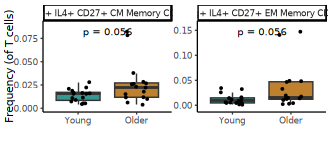

In [49]:
options(repr.plot.width = 70/25.4, repr.plot.height = 30/25.4)

p<-ggplot(freq_df_subset, aes( x = `Age Group`, y = percentage, fill=`Age Group`)) +
    geom_boxplot(outlier.shape = NA,lwd=0.3) +
geom_point(position = position_jitter(width = 0.2),color="black", size=0.8,stroke=0) +
theme_classic(base_size=6)+  
stat_compare_means(aes(label = paste0("p = ", after_stat(p.format))),
    size=2,
    label.x=1.25,  
    vjust = 0.5)+
    scale_fill_manual(values = c("Older" = '#bf812d', "Young" = '#35978f'))+
    scale_y_continuous(limits = c(NA, NA), 
                       expand = expansion(mult = c(0.1, 0.15)))+
theme(legend.position="none")+
xlab('')+
ylab('Frequency (of T cells)')+facet_wrap(~Final_Celltype,scale="free")


p
ggsave('FigureA.pdf',p,width = 60/25.4,height = 30/25.4)